# Import


In [41]:
import warnings

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from mne.decoding import CSP, PSDEstimator
from sklearn.base import BaseEstimator, ClassifierMixin
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.svm import SVC
from sklearn.preprocessing import FunctionTransformer
from sklearn.pipeline import make_pipeline

import moabb
from moabb.datasets import BNCI2014_001
from moabb.evaluations import CrossSessionEvaluation
from moabb.paradigms import LeftRightImagery

moabb.set_log_level("info")
warnings.filterwarnings("ignore")

# Instantiate dataset

**Datased used is BCI Competition IVa**


In [22]:
dataset = BNCI2014_001()
dataset.subject_list = [1, 2, 3, 4, 5, 6, 7, 8, 9]
paradigm = LeftRightImagery()
data = dataset.get_data(subjects=[1])
data[1]["0train"]["0"]

<RawArray | 26 x 96735 (386.9 s), ~19.2 MiB, data loaded>

# Create pipelines

**1** - CSP + SVM  
**2** - PSD + LDA


In [58]:
pipelines = {
    "csp+lda": make_pipeline(CSP(n_components=6), LDA()),
    "psd+svm": make_pipeline(
        PSDEstimator(fmin=7, fmax=31, sfreq=250),
        FunctionTransformer(lambda X: X.reshape(X.shape[0], -1)),
        SVC(kernel="linear"),
    ),
}

# Evaluate


In [59]:
evaluation = CrossSessionEvaluation(paradigm=paradigm, datasets=[dataset], overwrite=True)
results = evaluation.process(pipelines)
results

2025-06-27 19:22:56,670 INFO MainThread moabb.evaluations.base Processing dataset: BNCI2014-001
BNCI2014-001-CrossSession:   0%|          | 0/9 [00:00<?, ?it/s]

2025-06-27 19:22:59,145 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 1 | 0train: Score 0.937
2025-06-27 19:22:59,509 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 1 | 1test: Score 0.974
2025-06-27 19:23:00,110 INFO MainThread moabb.evaluations.base psd+svm | BNCI2014-001 | 1 | 0train: Score 0.781
2025-06-27 19:23:00,721 INFO MainThread moabb.evaluations.base psd+svm | BNCI2014-001 | 1 | 1test: Score 0.720
BNCI2014-001-CrossSession:  11%|█         | 1/9 [00:04<00:33,  4.15s/it]2025-06-27 19:23:03,546 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 2 | 0train: Score 0.543
2025-06-27 19:23:03,891 INFO MainThread moabb.evaluations.base csp+lda | BNCI2014-001 | 2 | 1test: Score 0.626
2025-06-27 19:23:04,512 INFO MainThread moabb.evaluations.base psd+svm | BNCI2014-001 | 2 | 0train: Score 0.551
2025-06-27 19:23:05,178 INFO MainThread moabb.evaluations.base psd+svm | BNCI2014-001 | 2 | 1test: Score 0.558
BNCI2014-001-CrossSession:  22%|██▏ 

,score,time,samples,subject,session,channels,n_sessions,dataset,pipeline
0,0.937307,0.248535,144.0,1,0train,22,2,BNCI2014-001,csp+lda
1,0.974344,0.253521,144.0,1,1test,22,2,BNCI2014-001,csp+lda
2,0.543403,0.254633,144.0,2,0train,22,2,BNCI2014-001,csp+lda
3,0.626350,0.248654,144.0,2,1test,22,2,BNCI2014-001,csp+lda
4,0.992670,0.253277,144.0,3,0train,22,2,BNCI2014-001,csp+lda
5,0.995563,0.253610,144.0,3,1test,22,2,BNCI2014-001,csp+lda
6,0.826003,0.241019,144.0,4,0train,22,2,BNCI2014-001,csp+lda
7,0.825424,0.256523,144.0,4,1test,22,2,BNCI2014-001,csp+lda
8,0.665895,0.248890,144.0,5,0train,22,2,BNCI2014-001,csp+lda
9,0.612654,0.245808,144.0,5,1test,22,2,BNCI2014-001,csp+lda


# Plot


(0.5, 1.0)

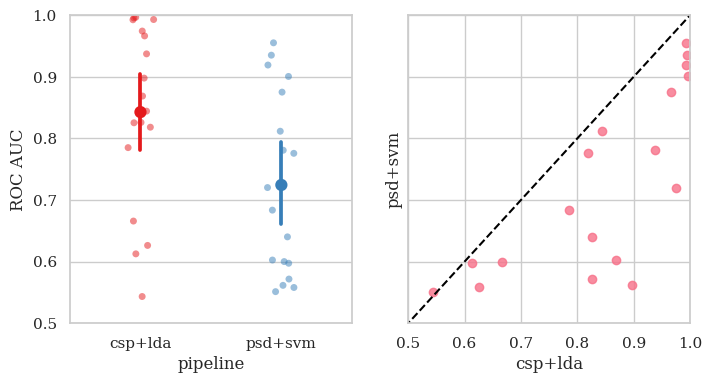

In [40]:
fig, axes = plt.subplots(1, 2, figsize=[8, 4], sharey=True)

sns.stripplot(
    data=results,
    y="score",
    x="pipeline",
    ax=axes[0],
    jitter=True,
    alpha=0.5,
    zorder=1,
    palette="Set1",
)
sns.pointplot(data=results, y="score", x="pipeline", ax=axes[0], palette="Set1")

axes[0].set_ylabel("ROC AUC")
axes[0].set_ylim(0.5, 1)

paired = results.pivot_table(values="score", columns="pipeline", index=["subject", "session"])
paired = paired.reset_index()

sns.regplot(data=paired, y="psd+svm", x="csp+lda", ax=axes[1], fit_reg=False)
axes[1].plot([0, 1], [0, 1], ls="--", c="k")
axes[1].set_xlim(0.5, 1)